In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pqr 

import src.f as f

In [3]:
prices = f.read_prices(path="./data/task2/stocks/")

rf = pd.read_csv(
    "./data/rf.csv", 
    index_col="Date", 
    parse_dates=True
).loc[:, "Price"]

# Задание

$$SR \ge 0.36, CAGR \ge 6.3\%$$

# Подготовка

Подготовим функцию для расчета доходности портфеля и бенчмарк - равновзвешенный индекс по имеющимся бумагам. Также подготовим таблицу с интересующими нас метриками и лог-график накопленной доходности.

In [4]:
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns, 
    universe_returns=pqr.prices_to_returns(prices),
)

benchmark = pqr.Benchmark.from_universe(
    universe=prices.notnull(),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

In [5]:
table = pqr.metrics.Table()
table.add_metric(
    metric=pqr.utils.partial(
        pqr.metrics.sharpe_ratio,
        annualizer=252,
        rf=rf / 252,
    ),
    name="Sharpe Ratio",
)
table.add_metric(
    metric=pqr.utils.partial(
        pqr.metrics.cagr,
        annualizer=252,
    ),
    multiplier=100,
    name="CAGR, %",
)

fig = pqr.metrics.Figure(
    metric=pqr.metrics.compounded_returns,
    name="Compounded Returns (log scale)",
    benchmark=benchmark,
    log_scale=True,
    kwargs={
        "figsize": (10, 6),
    },
)

summary = pqr.metrics.Dashboard([table, fig])

# Стратегия 1: Momentum

Сначала протестируем старый-добрый моментум. Будем считать моментум за 1 год и инвестировать с лагом в 1 месяц. Веса в портфеле равные. Квантиль - 20%

In [6]:
dynamic_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.look_back_pct_change, period=252),
    pqr.utils.partial(pqr.factors.lag, period=21),
    pqr.utils.partial(pqr.factors.hold, period=252),
)

mom = dynamic_transform(prices)

,Winners,Neutral 1,Neutral 2,Neutral 3,Losers
Sharpe Ratio,0.54,0.71,0.68,0.84,1.29
"CAGR, %",14.15,16.21,15.40,19.80,37.56


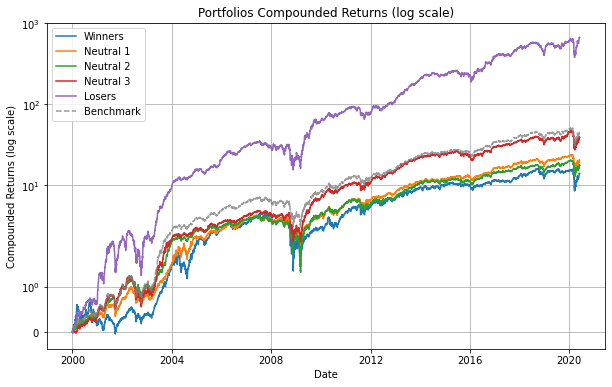

In [7]:
portfolios = pqr.factors.backtest_factor_portfolios(
    factor=mom,
    strategies=pqr.factors.split_quantiles(5, better="more"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

summary.display(portfolios)

С первого подхода уже получилось выбить необходимые показатели. На данной подвыборке акций, правда, сработал не моментум, а реверсал - выгодно брать максимально упавшие акции с задержкой в 1 месяц. На этой стратегии и остановимся. Итог:

1. Ребалансируемся ежегодно
2. Берем 20% с наименьшим моментумом за 1 год (252 торговых дня) с лагом в 1 месяц (21 торговый день)
3. Взвешиваем поровну

# Проверка устойчивости

Думаю, что нет особого смысла останавливаться надолго - в академической литературе огромное кол-во исследований, посвященных аномалиям моментума и реверсала - их существование уже давно доказано.

In [8]:
losers = portfolios[-1]
losers

Portfolio(name='Losers')

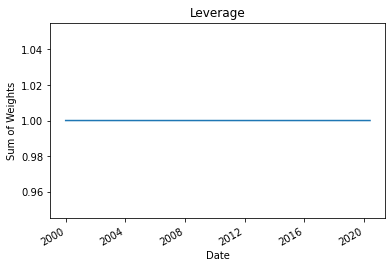

In [9]:
losers.holdings.sum(axis=1).plot(
    title="Leverage",
    xlabel="Date",
    ylabel="Sum of Weights"
);

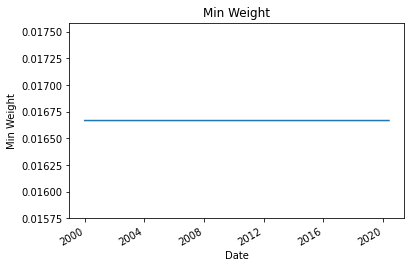

In [10]:
losers.holdings[losers.holdings != 0].min(axis=1).plot(
    title="Min Weight",
    xlabel="Date",
    ylabel="Min Weight",
);

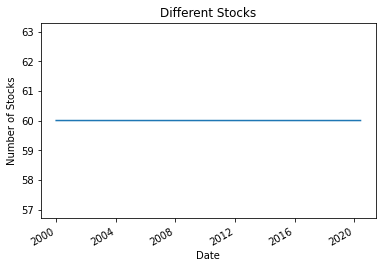

In [11]:
(losers.holdings > 0).sum(axis=1).plot(
    title="Different Stocks",
    xlabel="Date",
    ylabel="Number of Stocks",
);

In [12]:
(losers.holdings > 0).sum(axis=0).nlargest(10).rename("Most Popular Stocks")

SOFO    3024
SPPI    2867
AGHC    2867
LPTH    2867
MBOT    2772
WYY     2772
PLX     2615
AMSC    2615
CASI    2615
TRXC    2615
Name: Most Popular Stocks, dtype: int64

Использовался квантильный метод построения портфелей, поэтому все требования выполнены:

1. Акций в портфеле всегда чуть больше 60
2. Минимальный вес - 1.66%
3. Портфель загружен всегда на 100%

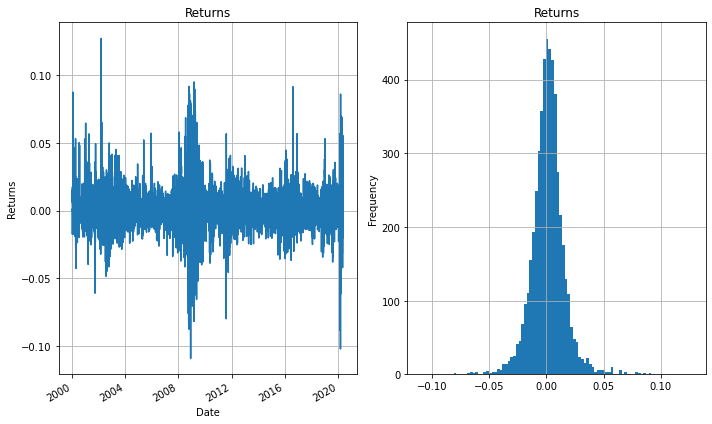

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

losers.returns.plot(
    ax=ax[0],
    title="Returns",
    xlabel="Date",
    ylabel="Returns",
    grid=True,
)

losers.returns.plot.hist(
    ax=ax[1],
    bins=100,
    title="Returns",
    xlabel="Date",
    ylabel="Returns",
    grid=True,
)

fig.tight_layout();

In [14]:
losers.returns.describe()

count    5135.000000
mean        0.001385
std         0.015439
min        -0.109292
25%        -0.006216
50%         0.001438
75%         0.008611
max         0.127166
dtype: float64

Доходность в целом несильно волатильна, но наблюдаются спайки (2008 и 2020 годы) - следствие того, что в кризисы портфель загружен на 100%. Распределение доходности похоже на нормальное, но немного смещено вправо, что говорит об эффективности стратеги.

P.s.: Есть ощущение, что так быстро и просто удалось достичь нужных результатов потому, что подвыборка акций сильно смещена - 300 компаний из почти 5000 на Американском рынке + из беглого анализа все или почти все с Nasdaq. При этом в выборке только те акции, которые торговались с 2000 по 2020 год - нет банкротов и делистингованных компаний. При реальном бэкстесте результаты наверняка будут ощутимо хуже.